# **Stage 2 - Deep Reinforcement Learning for Infinite Impulse Response (IIR) Filter Implementation - part 3** 

## Scope - *developing higher order IIR filters for complex interference situation*
References:- Chapter 11 of *Digital Signal Processing: signals, systems, and filters* by *Andreas Antoniou*

- In the earlier notebook, stage 2 - part 1, we modeled a second order IIR filter using a DDPG agent with a 5-dimensional action vector and successfully trained it to learn a meaningful and effective pole-zero configuration suitable for the given simple interference situation. 
- Now, my intention is to extend the environment to immitate complex interference situations with multiple static interference sources that ultimately creates non-overlapping interference with the target spectrum and also to increase the order of the current IIR filter. 
- With the above intentions in mind, let's list down what are the updates we shall make to the existing models. 
> - **update the current `create_target_and_jammed_signals` function from `stage1_helper.py` script** to create complex non-overlapping interference situations consisting of mulitple overlapping shifted audio spectrums. 
> - **allow the range of the magnitude of the zeros in the current IIR filter model to be in the range of $[0, \infty)$**, instead of the previous range used in the second order filtering, $[0, 1]$. The reason for choosing the previos range, which is upper-bounded by $1$, was self-explanatory since in a second order filter targeted for a non-overlapping interference with a single center frequency, an ideal pole-zero configuration will locate the zero on the unit circle $(r_z = 1)$ at the angle corresonding to the interferece center frequency, which was indeed the observation of the learned filter (see notebook for part 1). 
> - **extend the current environment to support 3rd and 4th order IIR filter.** 

- Ultimately, these updates must give us a solution to the current problem about the limitation of the dimensionality of the action space of DDPG. 

In [60]:
import os, sys, json
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.io import wavfile
from scipy.fft import irfft
from scipy.signal import lfilter, zpk2tf

import gymnasium as gym
from gymnasium import spaces

sys.path.append('../')
from stage1_helper import Spectrum, to_min_size_int_array, trim_audio, SNR
from stage2_helper import polar2cmplx, train
from DDPG import DDPGAgent

In [59]:
# DEFINE CONSTANTS
S = 100 # state size (length of the state audio sample sequence)
SAMPLING_FREQ = 44_100 # Hz
CUT_OFF_FREQ = 5_000 # Hz
INTERFERENCE_CENTER_FREQ = 15_000 # Hz

### **Task 1 - Update the Function for Creating the Target and Jammed Signals** 

In [43]:
# let's redefine the function here
def create_target_and_jammed_signals(
        audio_name: str, 
        truncation_freq: int | float, 
        interference_center_freq: int | float | list[int | float],
        signal_partition_size: int,
        interference_scalar: int | float | list[int | float] = 1,
        audio_file_dir: str = '../stage_1/audio_files/', 
        save_files: bool = False
    ):
    """
    Creates the target and jammed signals with the specified truncation frequnecy and the interference center frequencies.
    :param audio_name: name of the audio .wav file (without the .wav extension)
    :param truncation_freq: the frequency to truncate the spectrum of the given audio to generate the target signal
    :param interference_center_freq: the frequency or the frequencies to shift the target spectrum to generate the non-overlapping interference. \
        (``truncation_freq`` and ``interference_center_freq`` must be chosen appropriately to create a non-overlapping interference with the target spectrum; \
        otherwise, errors will be raised.)
    :param signal_partition_size: the size of a signal partition considered to trim the audio signal
    :param interference_scalar: non-negative value/values to scale each interference component; must have the same number of elements as ``interference_center_freq``.
    :param audio_file_dir: the path to the directory containing the audio file
    :param save_files: boolean value indicating whether to write the resulting (MONO), truncated, and jammed signals

    Returns the target signal and the jammed signal.
    """

    SAMPLING_FREQ = 44_100 # each audio file must have a constant sampling freq to equally apply the truncation and interference center frequencies
    if type(interference_center_freq) == int or type(interference_center_freq) == float:
        interference_center_freq = [interference_center_freq]
    if type(interference_scalar) == int or type(interference_scalar) == float:
        interference_scalar = np.ones((len(interference_center_freq), )) * interference_scalar

    print(f"audio name: '{audio_name}'")

    # ------------------------------------------ read the input audio ------------------------------------------
    audio_src_file = os.path.join(audio_file_dir, audio_name+'.wav')
    if not os.path.exists(audio_src_file):
        raise Exception(f"the specified audio file doesn't exist: given {audio_src_file}")
    sampling_rate, audio = wavfile.read(audio_src_file)
    sampling_space = 1/sampling_rate
    print(f"sampling rate: {sampling_rate} Hz")

    if (sampling_rate != SAMPLING_FREQ):
        raise Exception(f"Error - the sampling rate must be equal to {SAMPLING_FREQ}Hz: given {sampling_rate}")
    if (min(interference_center_freq) < 2 * truncation_freq):
        raise Exception(f"Error - non-overlapping interferene is impossible with the provided truncation and interference center frequencies: given {truncation_freq} and {interference_center_freq}")
    # if (interference_center_freq + truncation_freq > sampling_rate):
    #     raise Exception(f"Error - interference signal surpasses the sampling freqency of the original audio.")

    # ----------------------------------------- converting to MONO audio ---------------------------------------
    print(f"audio shape: {audio.shape}")
    print(f"data type: {audio.dtype}")
    
    if len(audio.shape) == 1: # MONO
        print("MONO audio file...")
        
    elif len(audio.shape) == 2 and audio.shape[-1] == 2: # STEREO
        print("converting audio from STEREO to MONO...")
        audio = np.average(audio, axis=-1).astype(audio.dtype)
        print(f"\taudio shape: {audio.shape}")
        print(f"\tdata type  : {audio.dtype}")

        # if save_files:
        # saving the MONO audio file
        mono_dst_file = os.path.join(audio_file_dir, audio_name+'-MONO.wav')
        print(f"\tsaving MONO audio: '{mono_dst_file}'...")
        wavfile.write(mono_dst_file, rate=sampling_rate, data=audio)
    else:
        raise TypeError("unsupported wav file format")

    # --------------------------------------- creating the target signal ---------------------------------------
    print(f"generating the target signal...")
    freq_bins, spectrum = Spectrum(audio, sampling_space=sampling_space, type='complex')

    # apply the cut-off frequency to audio spectrum 
    print(f"\ttruncating the spectrum at {truncation_freq}Hz")
    rect_filter = (freq_bins < truncation_freq).astype(np.uint8)
    target_spectrum = spectrum * rect_filter
    target_signal = to_min_size_int_array(irfft(target_spectrum)) # converting to an integer format #######

    # trim the signal (until a partition with sufficient non-zero audio samples)
    target_signal = trim_audio(target_signal, signal_partition_size)

    if save_files:
        # save the target signal
        target_dst_file = os.path.join(audio_file_dir, audio_name + "-target-MONO.wav")
        print(f"saving target signal: '{target_dst_file}'...")
        wavfile.write(target_dst_file, rate=sampling_rate, data=target_signal)
    
    # ---------------------------------------- create the jammed signal -----------------------------------------
    print(f"generating the jammed signal...")

    # creating a non-overlapping interference signal 
    print(f"\tcreating a non-overlapping interference signal with target spectrum shifted to {', '.join(map(str, interference_center_freq))}Hz with scales {', '.join(map(str, interference_scalar))}")
    t = np.arange(len(target_signal)) * sampling_space
    jammed_signal = target_signal.astype(np.int32)
    
    for i in range(len(interference_center_freq)):
        interference = (2 * target_signal * np.cos(2*np.pi*interference_center_freq[i]*t)) # .astype(default_dtype) # converting to np.int32
        # generate the jammed signal
        jammed_signal = to_min_size_int_array(jammed_signal + interference_scalar[i] * interference) #.astype(np.int16)

    if save_files:
        # save the jammed signal
        jammed_dst_file = os.path.join(audio_file_dir, audio_name + "-jammed-MONO.wav")
        print(f"saving jammed signal: '{jammed_dst_file}'...")
        wavfile.write(jammed_dst_file, rate=sampling_rate, data=jammed_signal)

    return target_signal, jammed_signal

In [52]:
target, jammed = create_target_and_jammed_signals(
    audio_name = 'vignesh',
    truncation_freq = 5_000, # Hz
    interference_center_freq = [12_000, 18_000], # Hz
    interference_scalar = [1, 1], 
    signal_partition_size = S,
)

audio name: 'vignesh'
sampling rate: 44100 Hz
audio shape: (136477,)
data type: int16
MONO audio file...
generating the target signal...
	truncating the spectrum at 5000Hz
	converting from float64 to <class 'numpy.int16'>; array ranges from min: -13841.346435316103 (>=-32768) to max: 14399.410754652867 (<=32767)
	trimming the audio signal...
		truncating the audio at lower 0 and upper -1 indices
generating the jammed signal...
	creating a non-overlapping interference signal with target spectrum shifted to 12000, 18000Hz with scales 1, 1
	converting from float64 to <class 'numpy.int32'>; array ranges from min: -40397.67357435536 (>=-2147483648) to max: 41413.510195372364 (<=2147483647)
	converting from float64 to <class 'numpy.int32'>; array ranges from min: -64004.80631559954 (>=-2147483648) to max: 68607.6178411572 (<=2147483647)


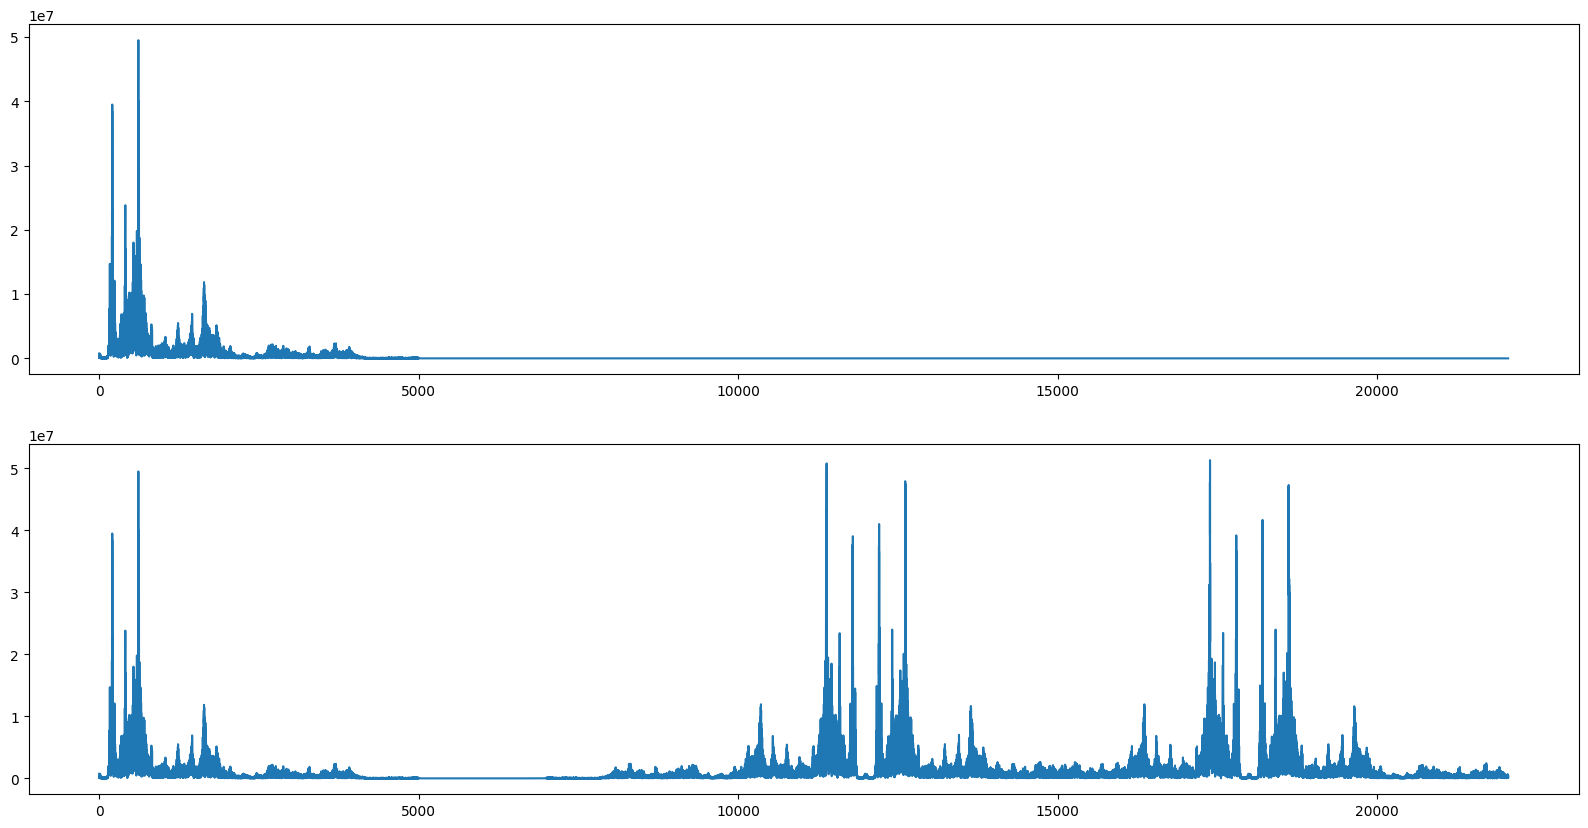

In [53]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))

ax[0].plot(*Spectrum(target, sampling_space=1/SAMPLING_FREQ))
ax[1].plot(*Spectrum(jammed, sampling_space=1/SAMPLING_FREQ))

### **Redefine the Environment**
- This time, let's use the trick of providing a normalized audio sequence as the state to the DDPG agent (see stage 3 part 1), which seems to stabalize the learning compared to the previous observations (see stage 2 part 1). 

In [55]:
def NormalizeState(state):
    """
    Normalizes a given state (equivalent to performing layer normalization)
    :param state: the state (observation) (1-D) vector to normalize
    """

    return (state - np.mean(state)) / np.std(state)

In [58]:
# receiver environment with IIR filtering
class ReceiverEnvWithSecondOrderIIR_1(gym.Env):
    """
    A custom environment developed in the accordance with gym environment API that immitates a receiver of jammed audio with IIR filtering. 
    :param S: signal partition size which represents a state 
    :param cut_off_freq: the frequency to truncate the audio spectrum to generate the target signal; equivalent to the ideal cut-off frequency of the learned filter
    :param interference_center_freq: the frequency to shift the target spectrum to generate the non-overlapping interference
    :param audio_json: path of a json file containing the names of the audio wav files the environment can access\
        put the audio file names without the .wav extension in a json array inside the file
    """

    # define constants 
    MIN_BUFFER_SIZE = 10 # RAISE THIS LATER!!!
    EPISODE_LENGTH  = np.inf # np.inf
    MAX_TOTAL_NUM_OF_STEPS = np.inf
    # OBSERVATION_SPACE_BOUND = 5

    def __init__(self, S:int, cut_off_freq:int, interference_center_freq:int, audio_json:str = '../stage_1/audio_files/audio_files.json'):

        super(ReceiverEnvWithSecondOrderIIR_1, self).__init__()

        # ----- verifying input arguments and setting them as class atributes ----
        # signal partition size
        if S < self.MIN_BUFFER_SIZE:
            raise Exception(f"the buffer size 'S' must be larger than MIN_BUFFER_SIZE, {self.MIN_BUFFER_SIZE}: given {S}")
        self.S = S

        # other parameters
        self.cut_off_freq = cut_off_freq
        self.interference_center_freq = interference_center_freq
        self.audio_json = audio_json

        # ----------------------------- Action Space -----------------------------
        # action - choosing fixed gain k, zeros, and poles of an N-th order IIR filter
        # note that the action is NOT TUNING/,ADJUSTING, or CHANGING the coefficeints of an existing filter. 
        action_shape = (5, )
        self.action_space = spaces.Box(low=0, high=1, shape=action_shape, dtype=np.float32) # float16 -> float32, lower limit must be 0. 

        # ----------------------------- State Space ------------------------------
        state_shape = (self.S, )
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=state_shape, dtype=np.float64)

        # ------------------------- other class attributes ------------------------
        self.global_counter = 0  # a counter to keep track of the number of elapsed time steps of the environment
        self.counter = 0         # a counter to keep track of the number of elapsed time steps in the current episode
        self.episode_counter = 0 # a counter to keep track of the number of total episodes

    def reset(self, seed=None, options=None):

        super().reset(seed=seed, options=None) # options must be forced to None

        # set show_effect option
        self.show_effect = True
        if isinstance(options, dict) and 'show_effect' in options:
            self.show_effect = options['show_effect']
        
        # reset the counters
        if isinstance(options, dict) and 'reset_all' in options and options['reset_all'] == True:
            self.global_counter  = 0
            self.episode_counter = 0
        self.counter = 0
        self.episode_counter += 1

        print('\n' + "-" * 50 + f"episode no: {self.episode_counter}" + "-" * 50)

        # for each episode, choose the audio signal specified by `audio_num` in the options
        with open(self.audio_json) as audio_json_file:
            train_audio_names = json.load(audio_json_file)["train"]
        audio_num = 1 # default audio track - 'arms_around_you-MONO.wav'
        if isinstance(options, dict) and 'audio_num' in options:
            audio_num = options['audio_num']
        
        # i = np.random.randint(low=1, high=self.audio_num) # len(train_audio_names)
        # create the target and jammed signals
        target_signal, jammed_signal = create_target_and_jammed_signals(train_audio_names[audio_num], self.cut_off_freq, self.interference_center_freq, self.S)
        self.target_signal = target_signal
        self.jammed_signal = jammed_signal
        print()

        # create another internal state
        self.internal_state = jammed_signal[:self.S]

        # return the initial state 
        self.state = NormalizeState(self.internal_state)

        # declare the initial conditions in the start of the audio
        self.initial_conds = np.zeros(2)

        info = {}

        # return the initial state and info
        return self.state, info

    def step(self, action):

        # increment the counters
        self.global_counter += 1
        self.counter += 1

        # ----- create the filter -----
        # extract the zero, pole, and gain, and find the transfer function of the filter
        z = polar2cmplx(np.tan(np.pi/2 * action[0]), np.pi * action[1])
        p = polar2cmplx(action[2], np.pi * action[3])
        k = action[4]

        zs = (z, np.conjugate(z)) # array of zeros of TF
        ps = (p, np.conjugate(p)) # array of poles of TF

        b, a = zpk2tf(zs, ps, k)

        # get signal partition from the buffer (internal state)
        partition = self.internal_state

        # generating the next state
        terminated = False
        if self.S * (self.counter + 1) >= len(self.jammed_signal):
            terminated = True
        else:
            self.internal_state = self.jammed_signal[self.S * self.counter : self.S * (self.counter + 1)]
            self.state = NormalizeState(self.internal_state)
        
        # apply the IIR filter to the current state and set the initial conditions for the next state
        filtered, self.initial_conds = lfilter(b, a, partition, zi=self.initial_conds)
        target = self.target_signal[self.S * (self.counter - 1) : self.S * self.counter]

        # calculate the reward (SNR)
        reward = SNR(target, filtered)
        if np.isnan(reward):
            print(f"reward value is not a number... \nfilter: {filter}; assigning -20dB as the reward...")
            reward = -20 # assign a very large negative reward
            # raise Exception(f"reward value is not a number...\ntarget: {target}\nfiltered: {filtered}\nfilter: {filter}")
        
        # if self.counter % 50 == 1:
        if self.show_effect: print(f"step: {self.counter}, SNR: {reward}, filter: {b}, {a}")
        
        # truncating the episode
        truncated = False
        if self.episode_counter == self.EPISODE_LENGTH or self.global_counter == self.MAX_TOTAL_NUM_OF_STEPS:
            truncated = True
        
        info = {} 

        return self.state, reward, terminated, truncated, info

    def render(self):
        pass

    def close(self):
        pass

In [ ]:
# declare the environment
env = ReceiverEnvWithSecondOrderIIR_1(S, cut_off_freq=CUT_OFF_FREQ, interference_center_freq=INTERFERENCE_CENTER_FREQ)

# train the model
reward_history_arr = []; action_history_arr = [][:]
train_time_steps = 128*20
for i in range(5):

    # launch a DDPG agent
    keras.backend.clear_session()
    model = DDPGAgent(
        input_dims  = env.observation_space.shape,
        n_actions   = env.action_space.shape[0],
        alpha       = 0.0001, # learning rate of actor
        beta        = 0.001,  # learning rate of critic
        gamma       = 0.1,
        tau         = 0.001,
        critic_fc1  = 512,
        critic_fc2  = 256, #...
        actor_fc1   = 256,
        actor_fc2   = 128,
        batch_size  = 128,
        buffer_size = 2000,
        noise       = 0.01
    )

    reward_history, action_history = train(model, env, audio_num=1, max_num_steps=train_time_steps, show_effect=False)
    reward_history_arr.append(reward_history)
    action_history_arr.append(action_history)